In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
import tensorflow as tf
import skimage.io as skio
tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
from image_processing2 import *

In [2]:
syntext = sio.loadmat('../data/sythtext/gt.mat')
syntext.keys()

['wordBB',
 'txt',
 '__header__',
 '__globals__',
 '__version__',
 'imnames',
 'charBB']

In [3]:
syntext['imnames'].shape

(1, 858750)

In [2]:
def int64_feature(value):
    """Wrapper for inserting int64 features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def float_feature(value):
    """Wrapper for inserting float features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [3]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(norm(i) * width) for i in bboxes[:,1]]
    ymin = [int(norm(i) * height) for i in bboxes[:,0]]
    ymax = [int(norm(i) * height) for i in bboxes[:,2]]
    xmax = [int(norm(i) * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,0,0))
    skio.imshow(image)
    skio.show()

name SparseTensor(indices=Tensor("ParseSingleExample_8/Slice_Indices_image/name:0", shape=(?, 1), dtype=int64), values=Tensor("ParseSingleExample_8/ParseExample/ParseExample:6", shape=(?,), dtype=string), dense_shape=Tensor("ParseSingleExample_8/Squeeze_Shape_image/name:0", shape=(1,), dtype=int64))
image after decode Tensor("decode_jpeg_8/convert_image:0", shape=(?, ?, 3), dtype=float32)
labels: Tensor("ExpandDims_53:0", shape=(1, ?), dtype=int64) 
(6,)
[[ 0.22636968  0.0014098   0.39598367  0.11941624]
 [ 0.03577822  0.43074378  0.08502093  0.72018576]
 [ 0.04083867  0.79822576  0.0927746   1.11262524]
 [ 0.12996271  0.4637067   0.19173186  0.92496753]
 [ 0.17585705  0.01889892  0.27164519  0.1014467 ]
 [ 0.17219256  0.45812416  0.28103027  1.11442733]]
(300, 300, 3)


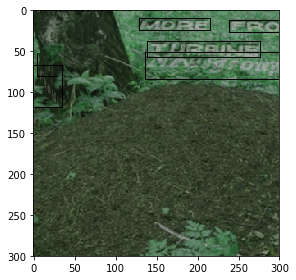

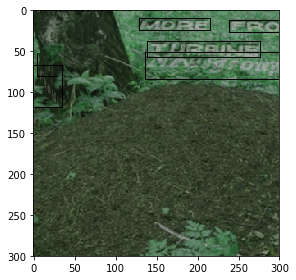

In [12]:
if __name__ == "__main__":
    data_dir = '/Users/xiaodiu/Documents/github/projecttextbox/TextBoxes-TensorFlow/data/sythtext/'
    file_name = data_dir + '1.tfrecord'
    ## test if file_name exists  

    example = tf.python_io.tf_record_iterator(file_name).next()
    image_buffer, label, bboxes, name= parse_example(example)

    image,label,bboxes,num = image_processing(image_buffer, bboxes,label,
                                         train= True, thread_id = 0)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Image, label, bboxes = sess.run([image, label, bboxes])
        print label.shape
        print bboxes
        #print name
        #print width
        #print height
        print Image.shape
        visualize_bbox(Image, bboxes)
        skio.imshow(Image)
        skio.show()